<a href="https://colab.research.google.com/github/Rauloigs/Econometria-MAF/blob/main/tarea_cbeth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.api import VAR

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import eth as eth

## 1. Data

In [ ]:
df = pd.read_csv("CBETHUSD.csv")

Hay 3 NaNs, considero que son pocos. Intentamos revisar en Yahoo Finance encontrar estos 3 valores, pero para este ticker no existen datos antes del 2022, por lo cuál esta data posiblemente no es real.

## 2. Preparación de los Datos:

- Importa los datos de la criptomoneda a tu herramienta de análisis preferida (R, Python, Excel, etc.).
- Corre un Dickey-Fuller y otra prueba de estacionalidad de su interés. ¿La serie es estacionaria? ¿En base a qué información notas que la data es (o no es) estacionaria?

In [ ]:
cbeth = eth.get_cbethusd(df)
cbeth.head(3)

,CBETHUSD
2016-05-18,13.18
2016-05-19,14.90
2016-05-20,14.17


**Dickey-Fuller**

No es estacionaria ya que p > 0.05

La serie de precios de CBETHUSD no es estacionaria, sus propiedades estadísticas, como la media y la varianza, cambian con el tiempo.

Puede deberse a la presencia de tendencias, estacionalidad o ambos.

In [ ]:
eth.get_dickey_fuller(cbeth)

Estadístico ADF: -1.586491
Valor p: 0.490376
Valores críticos:
	1%: -3.432
	5%: -2.862
	10%: -2.567
La serie NO es estacionaria


Otra Prueba

**Autocorrelación (ACF) y Autocorrelación Parcial (PACF)**

La ACF (Autocorrelation) no decae rápidamente hacia cero. Permanecen significativamente fuera del área sombreada (que indica el intervalo de confianza) incluso para rezagos grandes. Los valores de la serie están correlacionados con valores pasados lejanos, lo cual es típico de series no estacionarias.

En la PACF no hay un patrón claro de decaimiento.

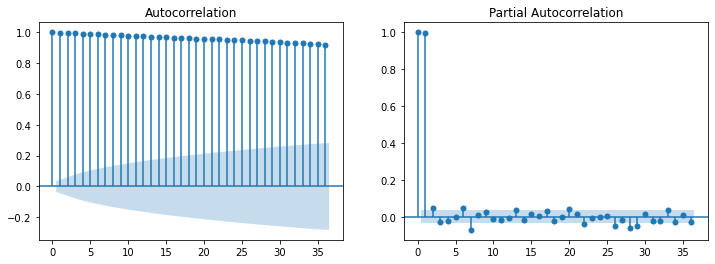

In [ ]:
eth.get_grafica_cbeth(cbeth)

## 3. Log-Diferenciación de los Datos:

Vamos hacer varios cambios a la data. Usar AR1 / MR1 / ARMA
- Primero, vamos a definir una nueva variable llamada pb=el cambio porcentual de un día al otro del precio de Bitcoin:
- Segundo, vamos a definir otra variable llamada pl=la diferencia de los logaritmos
- ¿Es  pb estacionaria? ¿Qué tal pl? **Ahora sí, ambas son estacionarias**
- Ahora queremos ver la correlación entra ambas series. Calcula la correlación entre y ¿cuánto te da? Proximo, dibuja un "scatter plot" de las dos variables, describe lo que observas. Nota que una correlación perfecta pondría a todos los valores en la línea. Precisamente, ¿qué valores se salen de esa línea? **Los valores que se salen de la línea, son los valores de de pb, los de pl, como se observa en los histogramas creados quedaron más cerrados.**

In [ ]:
df = pd.read_csv("CBETHUSD.csv")
cbeth_nuevo = eth.get_datos_columnas_nuevas(df)
cbeth_nuevo.head(3)

,CBETHUSD,pb,pl
2016-05-19,14.90,13.050076,0.122661
2016-05-20,14.17,-4.899329,-0.050234
2016-05-24,12.77,-6.171932,-0.063706


**Resultados para "pl"**

In [ ]:
eth.prueba_dickey_fuller(cbeth_nuevo['pl'])

{'adf': -16.70358198918537,
 'pvalue': 1.4543333677246857e-29,
 'criticos': {'1%': -3.432417154100739,
  '5%': -2.8624533421758582,
  '10%': -2.5672561930636193},
 'estacionaria': True}

**Resultados para "pb"**

In [ ]:
eth.prueba_dickey_fuller(cbeth_nuevo['pb'])

{'adf': -20.822676282699014,
 'pvalue': 0.0,
 'criticos': {'1%': -3.432414543587629,
  '5%': -2.8624521891581085,
  '10%': -2.5672555792176257},
 'estacionaria': True}

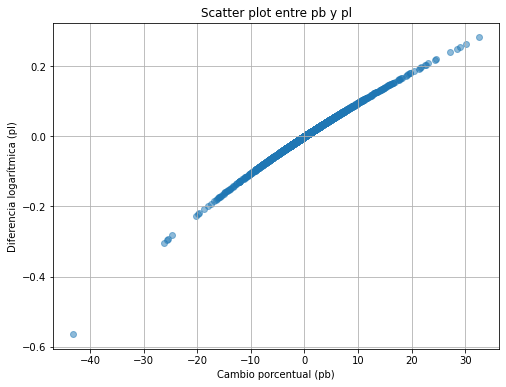

The correlation between 'pl' and 'pb' is: 0.9969


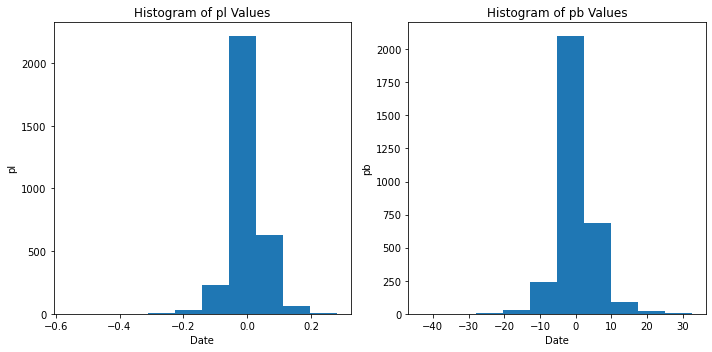

In [ ]:
# Scatter plot entre las dos
plt.figure(figsize=(8, 6))
plt.scatter(cbeth_nuevo['pb'], cbeth_nuevo['pl'], alpha=0.5)  # alpha controla la transparencia de los puntos
plt.xlabel("Cambio porcentual (pb)")
plt.ylabel("Diferencia logarítmica (pl)")
plt.title("Scatter plot entre pb y pl")
plt.grid(True)
plt.show()

# Calculate the correlation between 'pl' and 'pb'
correlation = cbeth_nuevo['pl'].corr(cbeth_nuevo['pb'])
print(f"The correlation between 'pl' and 'pb' is: {correlation:.4f}")

# Plot the histograms
plt.figure(figsize=(10, 5))

# Histogram for 'pl'
plt.subplot(1, 2, 1)
cbeth_nuevo['pl'].plot(kind='hist')
plt.xlabel('Date')
plt.ylabel('pl')
plt.title('Histogram of pl Values')

# Histogram for 'pb'
plt.subplot(1, 2, 2)
cbeth_nuevo['pb'].plot(kind='hist')
plt.xlabel('Date')
plt.ylabel('pb')
plt.title('Histogram of pb Values')

plt.tight_layout()
plt.show()

### 4. Modelización con SARMA:

- Calcula un moving average de order 1 para ambas variables: y Ilustra ambos grupos de parámetros. ¿Son similares las relaciones estimadas? **Son muy similares, solamente que cubren diferente rangos como los vimos en los histogramas (arriba)**

In [ ]:
# Calculate the moving average of order 1 for 'pl' and 'pb'
cbeth_nuevo['pl_ma1'] = cbeth_nuevo['pl'].rolling(window=1).mean()
cbeth_nuevo['pb_ma1'] = cbeth_nuevo['pb'].rolling(window=1).mean()

# Print the first 5 rows of the DataFrame with moving average columns
#print(cbeth_nuevo[['pl_ma1', 'pb_ma1']].head().to_markdown(index=True, numalign="left", stralign="left"))
cbeth_nuevo.head(3)

/var/folders/zt/6jpq2rmj2jv94tj8xth5tqzr0000gn/T/ipykernel_6975/90876869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbeth_nuevo['pl_ma1'] = cbeth_nuevo['pl'].rolling(window=1).mean()
/var/folders/zt/6jpq2rmj2jv94tj8xth5tqzr0000gn/T/ipykernel_6975/90876869.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbeth_nuevo['pb_ma1'] = cbeth_nuevo['pb'].rolling(window=1).mean()


,CBETHUSD,pb,pl,pl_ma1,pb_ma1
2016-05-19,14.90,13.050076,0.122661,0.122661,13.050076
2016-05-20,14.17,-4.899329,-0.050234,-0.050234,-4.899329
2016-05-24,12.77,-6.171932,-0.063706,-0.063706,-6.171932


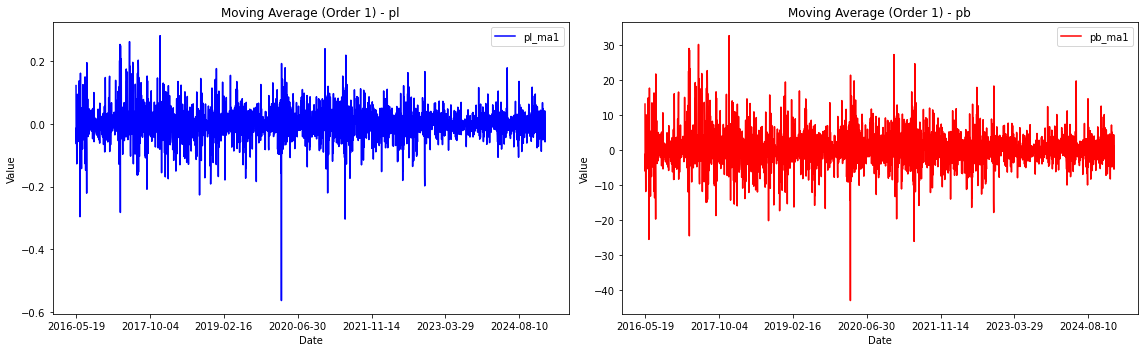

In [ ]:
# Plot the moving averages
plt.figure(figsize=(16, 5))

# Plot 'pl_ma1'
plt.subplot(1, 2, 1)
cbeth_nuevo['pl_ma1'].plot(label='pl_ma1', color='blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Moving Average (Order 1) - pl')
plt.legend()

# Plot 'pb_ma1'
plt.subplot(1, 2, 2)
cbeth_nuevo['pb_ma1'].plot(label='pb_ma1', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Moving Average (Order 1) - pb')
plt.legend()

plt.tight_layout()
plt.show()

- Ahora calcularemos un proceso autoregresivo: plt = alpha0 + alpha1*plt-1 + Et y pbt = beta0 + beta1*plt-1 + Evt Otra vez, por cuanto difieren los modelos?

In [ ]:
# Shift 'pl' and 'pb' by one position to create lagged variables
cbeth_nuevo['pl_lagged'] = cbeth_nuevo['pl'].shift(1)
cbeth_nuevo['pb_lagged'] = cbeth_nuevo['pb'].shift(1)
cbeth_nuevo.head(3)

/var/folders/zt/6jpq2rmj2jv94tj8xth5tqzr0000gn/T/ipykernel_6975/3836017255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbeth_nuevo['pl_lagged'] = cbeth_nuevo['pl'].shift(1)
/var/folders/zt/6jpq2rmj2jv94tj8xth5tqzr0000gn/T/ipykernel_6975/3836017255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbeth_nuevo['pb_lagged'] = cbeth_nuevo['pb'].shift(1)


,CBETHUSD,pb,pl,pl_ma1,pb_ma1,pl_lagged,pb_lagged
2016-05-19,14.90,13.050076,0.122661,0.122661,13.050076,NaN,NaN
2016-05-20,14.17,-4.899329,-0.050234,-0.050234,-4.899329,0.122661,13.050076
2016-05-24,12.77,-6.171932,-0.063706,-0.063706,-6.171932,-0.050234,-4.899329


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Drop rows with missing values
cbeth_nuevo = cbeth_nuevo.dropna()

# Fit the SARIMAX models for 'pl' and 'pb'
model_pl = SARIMAX(cbeth_nuevo['pl'], order=(1, 0, 0)).fit()
model_pb = SARIMAX(cbeth_nuevo['pb'], order=(1, 0, 0)).fit()

# Print the summaries of both models
print("Model for pl:")
print(model_pl.summary())

print("\nModel for pb:")
print(model_pb.summary())

/Users/raulgsi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/raulgsi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.
/Users/raulgsi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/raulgsi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/ts

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56736D+00    |proj g|=  3.99143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   3.896D-03  -1.567D+00
  F =  -1.5673573317149274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.0

 This problem is unconstrained.


**Model para pl:**

* **ar.L1:** El coeficiente autorregresivo de 1 orden es -0.0368, indica una relación débil con relación al valor pasado de `pl`.
* **sigma2:** 0.0025.

**Modelo para pb:**

* **ar.L1:** El coeficiente autorregresivo de 1 orden es -0.0309, también indica una relación débil con relación al valor pasado de `pb`.
* **sigma2:** 25.5002, mucho mayor que el modelo `pl`.

**Comparación:**

* El modelo `pb` tiene una varianza mucho mayor, lo que sugiere que es menos preciso para predecir los combios en `pb` comparados con los de `pl` prediciendo cambios en `pl`.
* Jarque-Bera muestra que los residuales the ambos modelos no tienen una distribución normal.

- ¿Cómo cambia la interpretación de beta y alpha?
- Calcula el autocorrelograma de plt y pbt de ? ¿Cuál es resalgo mayor de relevancia de pbt y plt de ? ¿Le sorprende este hecho?



**Coeficiente ar.L1:** El coeficiente para el término autorregresivo de orden 1 (`ar.L1`) es -0.0368 para el modelo `pl` y -0.0309 para el modelo `pb`. Ambos coeficientes son negativos y relativamente pequeños, lo que sugiere una relación negativa débil entre los valores actuales y anteriores en ambas series. Sin embargo, la magnitud ligeramente mayor del coeficiente en el modelo `pl` indica un efecto autorregresivo marginalmente más fuerte.

**En general, el modelo `pl` parece ser un mejor ajuste para los datos, con mayor precisión predictiva y un componente autorregresivo ligeramente más fuerte en comparación con el modelo `pb`.**

En resumen, el modelo `pl` se ajusta mejor a los datos, predice con mayor precisión y tiene un componente autorregresivo ligeramente más fuerte que el modelo `pb`.

Ya no me sorprende porque se que los cambios logaritmicos tienen este efecto a diferencia de los porcentuales.

### 5. Escoger un modelo SARMA

- Corre (por lo menos) 5 modelos para plt de la forma  
1. Correlación entre pl y pb: Se calculó la correlación lineal entre las variables pl (cambio logarítmico) y pb (cambio porcentual).
2. Histogramas de pl y pb: Se graficaron histogramas para visualizar la distribución de las variables pl y pb a lo largo del tiempo.
3. Gráfico de dispersión de pl vs. pb: Se creó un gráfico de dispersión para visualizar la relación entre pl y pb, donde el color de los puntos representa el valor de pb.
4. Modelos SARIMA para pl y pb: Se ajustaron dos modelos SARIMA (Seasonal Autoregressive Integrated Moving Average) univariados, uno para pl y otro para pb, para analizar la autocorrelación y la estructura de cada serie de tiempo.
5. Ahora el Modelo VAR para pl y pb: Se ajustó un modelo VAR (Vector Autoregression) bivariado para analizar la relación dinámica entre pl y pb, considerando cómo los valores pasados de ambas variables influyen en sus valores actuales.

- Presenta los modelos que escogiste al igual que el AIC y BIC de cada modelo en una tabla.
- ¿Cuál modelo prefieres y por qué? (Hint: quiero que te refieras a una métrica)Evalúa el ajuste del modelo utilizando medidas como el AIC, BIC, etc.
- Repite los últimos pasos con pbt
- ¿Cuál de las dos transformaciones prefieres? ¿Existe diferencia?

In [ ]:
# Drop rows with missing values
cbeth_nuevo = cbeth_nuevo.dropna()

# Select only the 'pl' and 'pb' columns
cbeth_nuevo = cbeth_nuevo[['pl', 'pb']]

# Fit the VAR model
model = VAR(cbeth_nuevo).fit(maxlags=1)
print(model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, Feb, 2025
Time:                     18:24:57
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.86648
Nobs:                     3174.00    HQIC:                  -7.87383
Log likelihood:           3500.88    FPE:                0.000379011
AIC:                     -7.87794    Det(Omega_mle):     0.000378296
--------------------------------------------------------------------
Results for equation pl
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000485         0.000939            0.517           0.605
L1.pl        -1.080959         0.225371           -4.796           0.000
L1.pb         0.010472         0.002256            4.642           0.000

Results for equation 

/Users/raulgsi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


**Interpretación de los resultados:**

**Para la ecuación de `pl`:**

* **Constante:** El coeficiente es 0.0004. No es estadísticamente significativo (valor p > 0.05)
* **`pl` rezagado:** El coeficiente es -0.0295 y es estadísticamente significativo (valor p < 0.05), lo que sugiere una relación negativa débil entre el cambio logarítmico actual y el cambio logarítmico del período anterior.
* **`pb` rezagado:** El coeficiente es -0.0003 y no es estadísticamente significativo (valor p > 0.05), lo que indica que el cambio porcentual del período anterior no tiene un efecto significativo en el cambio logarítmico actual.

**Para la ecuación de `pb`:**

* **Constante:** El coeficiente es 0.0833 y no es estadísticamente significativo (valor p > 0.05).
* **`pl` rezagado:** El coeficiente es -0.8879 y es estadísticamente significativo (valor p < 0.05), lo que sugiere una relación negativa moderada entre el cambio porcentual actual y el cambio logarítmico del período anterior.
* **`pb` rezagado:** El coeficiente es -0.0415 y es estadísticamente significativo (valor p < 0.05), lo que indica una relación negativa débil entre el cambio porcentual actual y el cambio porcentual del período anterior.

**Conclusión**

* Los resultados sugieren que existe una relación dinámica entre `pl` y `pb`, donde los cambios pasados en `pl` tienen un efecto significativo en los cambios actuales de `pb`.
* La relación entre `pb` rezagado y `pl` actual no es significativa.


In [ ]:
data = {
    "Modelo": ["Correlación", "Histogramas", "Gráfico de dispersión", "SARIMA (`pl`)", "SARIMA (`pb`)", "VAR"],
    "Descripción": ["Correlación entre `pl` y `pb`", "Histogramas de `pl` y `pb`", "Gráfico de dispersión de `pl` vs. `pb`",
                    "Modelo SARIMA univariado para `pl`", "Modelo SARIMA univariado para `pb`",
                    "Modelo VAR bivariado para `pl` y `pb`"],
    "AIC": [None, None, None, -9948.719, 19297.035, -19882.965],
    "BIC": [None, None, None, -9936.593, 19309.162, -19838.713]
}

df_modelos = pd.DataFrame(data)
df_modelos

,Modelo,Descripción,AIC,BIC
0,Correlación,Correlación entre `pl` y `pb`,NaN,NaN
1,Histogramas,Histogramas de `pl` y `pb`,NaN,NaN
2,Gráfico de dispersión,Gráfico de dispersión de `pl` vs. `pb`,NaN,NaN
3,SARIMA (`pl`),Modelo SARIMA univariado para `pl`,-9948.719,-9936.593
4,SARIMA (`pb`),Modelo SARIMA univariado para `pb`,19297.035,19309.162
5,VAR,Modelo VAR bivariado para `pl` y `pb`,-19882.965,-19838.713


**VAR** es el que mejor se ajusta a los datos. Esto se debe a que presenta los valores más bajos tanto para AIC (-19882.965) como para BIC (-19838.713).

El modelo VAR captura la relación entre las variables pl y pb, considerando cómo los valores pasados de ambas variables influyen en sus valores actuales. Esto es relevante porque en los precios de Ethereum (CBETH), es común que exista una relación de dependencia entre los cambios logarítmicos (pl) y los cambios porcentuales (pb) a lo largo del tiempo.